<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Построение-прогнозных-моделей" data-toc-modified-id="Построение-прогнозных-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Построение прогнозных моделей</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#CatboostRegressor" data-toc-modified-id="CatboostRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>CatboostRegressor</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование количества заказов такси на следующий час

**Цель проекта:**
В данном проекте мы построим прогнозную модель для предсказывания количества заказов такси в аэропортах в период пиковой нагрузки, для определения оптимальной потребности в автомобилях.

**Состав проекта:**
 * Обзор данных
 * Анализ данных
 * Предобработка данных
 * Построение прогнозных моделей
 * Тестирование лучшей модели

**Оценка ключевых показателей:**
Ключевым показателем оценки модели выбрана метрика RMSE < 48
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

## Обзор данных

Подгрузим необходимые библиотеки.

In [1]:
# Импорт стандартных библиотек
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Импорт внешних библиотек
from statsmodels.tsa.seasonal import seasonal_decompose
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

Подгрузим необходимые данные.

In [2]:
# Подгрузка необходимых данных
try:
    data = pd.read_csv('D:\\Users\\BlackEdition\\Desktop\\Data Science\\'
                       'Обучение в Яндекс\\13. Временные ряды\\taxi.csv',
                       index_col=[0],
                       parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv',
                       index_col=[0],
                       parse_dates=[0])

Посмотрим на общую информацию о датасете.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Проверим даты на соответствие хронологическому порядку

In [5]:
data.index.is_monotonic

True

### Вывод

Из датасета видно, что у нас есть данные по заказам такси за каждые сутки, начиная с 01.03.2018 по 31.08.2018 с разбивкой на каждые 10 минут.
Данные сразу же приведены к необходимому для дальшейшего анализа формату - даты перенесены в индекс.
Из датасета видно, что данные находятся в правильном хронологическом порядке.

## Анализ данных

Проведем анализ имеющихся данных.

Для начала сгруппируем данные не по 10 минут, а по часам.

In [6]:
# Ресемплинг даты от 10-минутного формата к часовому
data = data.resample('1H').sum()

In [7]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Теперь разобьем данные на тренд и сезонность и проанализируем их на графиках.

In [8]:
# Разбивка данных на тренд, сезонность и шум
decomposed = seasonal_decompose(data)

Text(0.5, 1.0, 'Residuals')

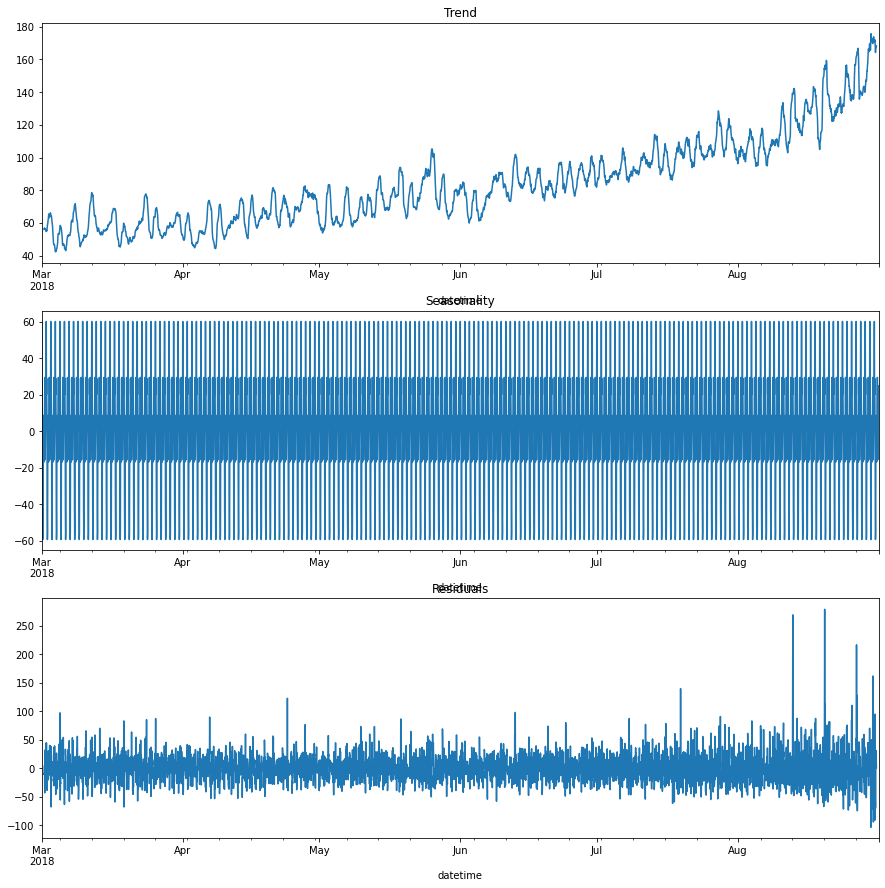

In [9]:
# Построение графиков тренда, сезонности и шума
plt.figure(figsize=(15, 15))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

Из графиков видно, что у заказов такси есть тренд - количество заказов от месяца к месяцу растет. Из графика тренда и сезонности нельзя сказать о какой-то существующей видимой сезонности заказов такси. Скорее всего это связано с тем, что аэропорты не имеют четко выраженной сезонности.

Рассмотрим график сезонности поближе - в разрезе 5 дней. Видно, что существуют отпределенные стационырные суточные колебания в количестве заказов такси.

<AxesSubplot:xlabel='datetime'>

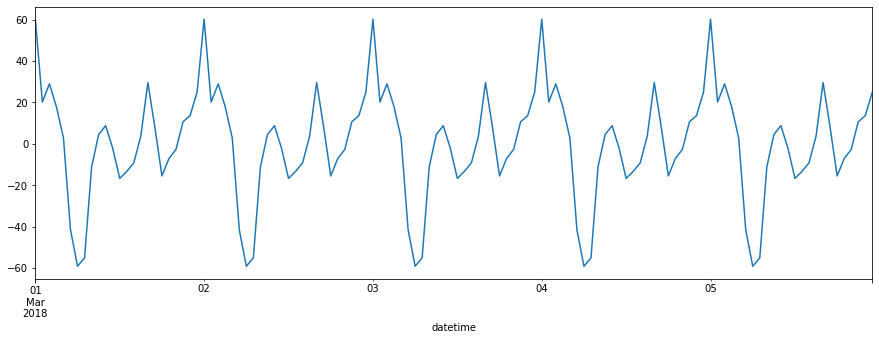

In [10]:
# Построение графика сезонности за 5 дней
plt.figure(figsize=(15, 5))
decomposed.seasonal['2018-03-01':'2018-03-05'].plot(ax=plt.gca())

Для определения суточных колебаний рассмотрим график дневного колебания. Из него видно, что пик активности в заказах такси приходится на ночное время. Скорее всего это связано с тем, что ночью в данном городе существует проблема с общественным транспортом, курсирующем от аэропота до ближайших транспортно-пересадочных узлов. К 6 часам утра количество заказов такси становится минимальным, т.к. обычно с 5 часов утра начинает курсировать общественный транспорт, а уровень пробок в это время минимальный.

<AxesSubplot:xlabel='datetime'>

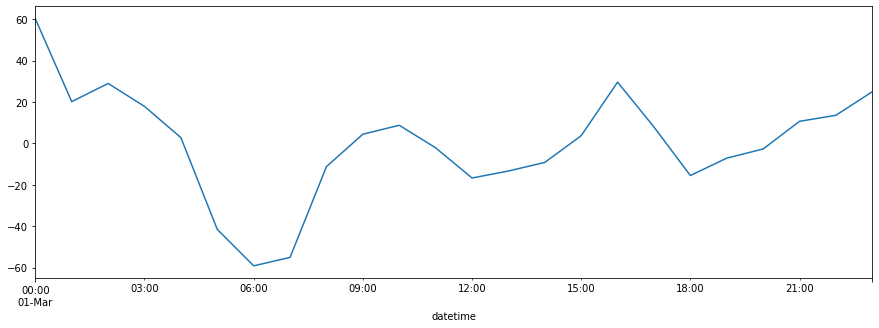

In [11]:
# Построение графика сезонности за 1 день
plt.figure(figsize=(15, 5))
decomposed.seasonal['2018-03-01':'2018-03-01'].plot(ax=plt.gca())

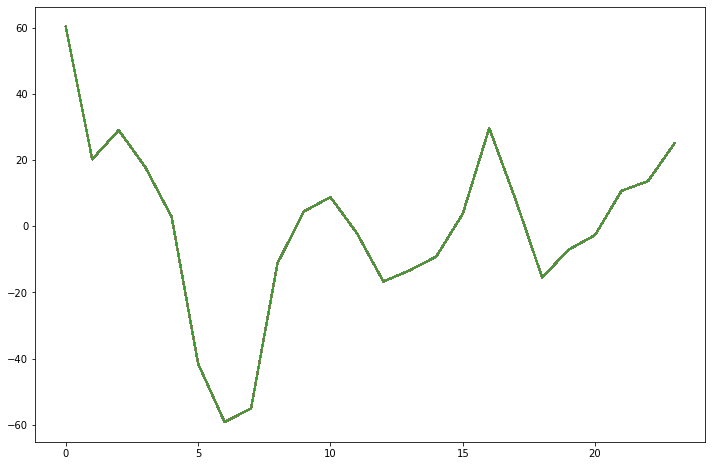

In [12]:
fig = plt.figure(figsize=(12, 8))
counter = 24
while counter < decomposed.seasonal.shape[0]:
    plt.plot(decomposed.seasonal[counter-24:counter].reset_index(drop=True), figure=fig)
    counter += 24

### Вывод

Из проведенного анализа данных мы имеем четкий тренд, заключаящийся в росте заказов такси в целом. Возможно это свзяано и с ростом авиаперевозок. Четко выраженная сезонность в заказах отсутствует. Суточные колебания заказов привалируют на ночное и вечернее время, с нижним экстремумом в утренние часы.

## Предобработка данных

Предобработаем данные для того, чтобы можно было обучить на них модель.

Для начала напишем функцию, которая создаст нам дополнительные фичи, которые помогут моделям обучаться.

In [13]:
# Фукнция для создания дополнительных фичей
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Передадим в нее датасет и необходимые значения.

In [14]:
make_features(data, 50, 50)  # Создание дополнительных фичей

Разобьем данные на train и test выборки, после чего отделим признаки от целевого признака.

In [15]:
train, valid = train_test_split(data,
                                shuffle=False,
                                test_size=0.6)

valid, test = train_test_split(valid,
                               shuffle=False,
                               test_size=0.25)
train = train.dropna()

In [16]:
# Разбивка на признаки и целевой признак
features_train = train.drop('num_orders', axis=1)
features_valid = valid.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)
target_train = train['num_orders']
target_valid = valid['num_orders']
target_test = test['num_orders']

display(features_train.shape)
display(target_train.shape)
display(features_valid.shape)
display(target_valid.shape)
display(features_test.shape)
display(target_test.shape)

(1716, 52)

(1716,)

(1987, 52)

(1987,)

(663, 52)

(663,)

### Вывод

Данные разбиты корректно. Мы получили дополнительные 50 признаков, на которых будет обучаться модель.

## Построение прогнозных моделей

Обучим различные модели и посмотрим на их метрики.

### LinearRegression

In [17]:
# Обучение LinearRegression
model_LR = LinearRegression()
model_LR.fit(features_train, target_train)
predictions_train = model_LR.predict(features_train)
predictions_valid = model_LR.predict(features_valid)
rmse_train = mean_squared_error(target_train, predictions_train) ** .5
rmse_valid = mean_squared_error(target_valid, predictions_valid) ** .5

display(f'Train RMSE: {rmse_train}')
display(f'Valid RMSE: {rmse_valid}')

'Train RMSE: 19.71015702484594'

'Valid RMSE: 26.43894937978503'

### LGBMRegressor

In [18]:
# Обучение LGBMRegressor
model_LGBM = LGBMRegressor()
model_LGBM.fit(features_train, target_train)
predictions_train = model_LGBM.predict(features_train)
predictions_valid = model_LGBM.predict(features_valid)
rmse_train = mean_squared_error(target_train, predictions_train) ** .5
rmse_valid = mean_squared_error(target_valid, predictions_valid) ** .5

display(f'Train RMSE: {rmse_train}')
display(f'Valid RMSE: {rmse_valid}')

'Train RMSE: 4.900248035539015'

'Valid RMSE: 26.68394296396196'

### CatboostRegressor

In [19]:
# Обучение CatBoostRegressor
model_CB = CatBoostRegressor()
model_CB.fit(features_train, target_train)
predictions_train = model_CB.predict(features_train)
predictions_valid = model_CB.predict(features_valid)
rmse_train = mean_squared_error(target_train, predictions_train) ** .5
rmse_valid = mean_squared_error(target_valid, predictions_valid) ** .5

display(f'Train RMSE: {rmse_train}')
display(f'Valid RMSE: {rmse_valid}')

Learning rate set to 0.04459
0:	learn: 30.4978362	total: 174ms	remaining: 2m 54s
1:	learn: 29.9022794	total: 188ms	remaining: 1m 33s
2:	learn: 29.3384583	total: 201ms	remaining: 1m 6s
3:	learn: 28.8078712	total: 212ms	remaining: 52.9s
4:	learn: 28.3132652	total: 225ms	remaining: 44.7s
5:	learn: 27.8536577	total: 236ms	remaining: 39s
6:	learn: 27.4250840	total: 245ms	remaining: 34.8s
7:	learn: 26.9811998	total: 257ms	remaining: 31.8s
8:	learn: 26.5201388	total: 270ms	remaining: 29.8s
9:	learn: 26.1272137	total: 283ms	remaining: 28s
10:	learn: 25.7572850	total: 298ms	remaining: 26.8s
11:	learn: 25.4471511	total: 312ms	remaining: 25.7s
12:	learn: 25.1360876	total: 340ms	remaining: 25.8s
13:	learn: 24.8157615	total: 356ms	remaining: 25.1s
14:	learn: 24.4924794	total: 372ms	remaining: 24.5s
15:	learn: 24.1755460	total: 387ms	remaining: 23.8s
16:	learn: 23.8745278	total: 402ms	remaining: 23.2s
17:	learn: 23.5888704	total: 414ms	remaining: 22.6s
18:	learn: 23.3539878	total: 424ms	remaining: 2

168:	learn: 14.7903287	total: 2.54s	remaining: 12.5s
169:	learn: 14.7637425	total: 2.58s	remaining: 12.6s
170:	learn: 14.7405952	total: 2.59s	remaining: 12.6s
171:	learn: 14.7241205	total: 2.6s	remaining: 12.5s
172:	learn: 14.6957236	total: 2.62s	remaining: 12.5s
173:	learn: 14.6818151	total: 2.63s	remaining: 12.5s
174:	learn: 14.6757652	total: 2.63s	remaining: 12.4s
175:	learn: 14.6605974	total: 2.64s	remaining: 12.4s
176:	learn: 14.6448168	total: 2.65s	remaining: 12.3s
177:	learn: 14.6247261	total: 2.66s	remaining: 12.3s
178:	learn: 14.6119193	total: 2.67s	remaining: 12.3s
179:	learn: 14.5826050	total: 2.68s	remaining: 12.2s
180:	learn: 14.5643477	total: 2.69s	remaining: 12.2s
181:	learn: 14.5206270	total: 2.7s	remaining: 12.1s
182:	learn: 14.5007704	total: 2.71s	remaining: 12.1s
183:	learn: 14.4855411	total: 2.72s	remaining: 12.1s
184:	learn: 14.4827044	total: 2.73s	remaining: 12s
185:	learn: 14.4723726	total: 2.74s	remaining: 12s
186:	learn: 14.4466827	total: 2.75s	remaining: 12s
1

337:	learn: 11.7741251	total: 4.46s	remaining: 8.73s
338:	learn: 11.7566904	total: 4.47s	remaining: 8.71s
339:	learn: 11.7274283	total: 4.48s	remaining: 8.7s
340:	learn: 11.7166387	total: 4.49s	remaining: 8.68s
341:	learn: 11.6931296	total: 4.5s	remaining: 8.66s
342:	learn: 11.6760011	total: 4.51s	remaining: 8.64s
343:	learn: 11.6700183	total: 4.52s	remaining: 8.62s
344:	learn: 11.6547562	total: 4.53s	remaining: 8.6s
345:	learn: 11.6326544	total: 4.54s	remaining: 8.58s
346:	learn: 11.6241446	total: 4.55s	remaining: 8.56s
347:	learn: 11.6076536	total: 4.56s	remaining: 8.54s
348:	learn: 11.5857278	total: 4.57s	remaining: 8.52s
349:	learn: 11.5784022	total: 4.58s	remaining: 8.5s
350:	learn: 11.5638691	total: 4.59s	remaining: 8.48s
351:	learn: 11.5540155	total: 4.59s	remaining: 8.46s
352:	learn: 11.5391582	total: 4.61s	remaining: 8.44s
353:	learn: 11.5227968	total: 4.61s	remaining: 8.42s
354:	learn: 11.5071631	total: 4.62s	remaining: 8.4s
355:	learn: 11.4976958	total: 4.63s	remaining: 8.38

500:	learn: 9.4509255	total: 6.25s	remaining: 6.22s
501:	learn: 9.4497890	total: 6.26s	remaining: 6.21s
502:	learn: 9.4351356	total: 6.28s	remaining: 6.2s
503:	learn: 9.4247986	total: 6.29s	remaining: 6.19s
504:	learn: 9.4057573	total: 6.3s	remaining: 6.17s
505:	learn: 9.3877146	total: 6.31s	remaining: 6.16s
506:	learn: 9.3667799	total: 6.32s	remaining: 6.14s
507:	learn: 9.3514457	total: 6.33s	remaining: 6.13s
508:	learn: 9.3390097	total: 6.34s	remaining: 6.11s
509:	learn: 9.3249400	total: 6.35s	remaining: 6.1s
510:	learn: 9.3081849	total: 6.36s	remaining: 6.08s
511:	learn: 9.2993850	total: 6.36s	remaining: 6.07s
512:	learn: 9.2802138	total: 6.37s	remaining: 6.05s
513:	learn: 9.2692713	total: 6.38s	remaining: 6.04s
514:	learn: 9.2579350	total: 6.39s	remaining: 6.02s
515:	learn: 9.2449482	total: 6.4s	remaining: 6s
516:	learn: 9.2298582	total: 6.41s	remaining: 5.99s
517:	learn: 9.2025681	total: 6.42s	remaining: 5.97s
518:	learn: 9.1856649	total: 6.43s	remaining: 5.96s
519:	learn: 9.17757

660:	learn: 7.7566634	total: 7.77s	remaining: 3.98s
661:	learn: 7.7461194	total: 7.78s	remaining: 3.97s
662:	learn: 7.7451538	total: 7.79s	remaining: 3.96s
663:	learn: 7.7393340	total: 7.8s	remaining: 3.94s
664:	learn: 7.7280414	total: 7.8s	remaining: 3.93s
665:	learn: 7.7204027	total: 7.81s	remaining: 3.92s
666:	learn: 7.7053017	total: 7.82s	remaining: 3.9s
667:	learn: 7.6964640	total: 7.83s	remaining: 3.89s
668:	learn: 7.6873369	total: 7.84s	remaining: 3.88s
669:	learn: 7.6781184	total: 7.85s	remaining: 3.87s
670:	learn: 7.6692140	total: 7.86s	remaining: 3.85s
671:	learn: 7.6588148	total: 7.87s	remaining: 3.84s
672:	learn: 7.6517376	total: 7.88s	remaining: 3.83s
673:	learn: 7.6390614	total: 7.89s	remaining: 3.81s
674:	learn: 7.6294432	total: 7.89s	remaining: 3.8s
675:	learn: 7.6189457	total: 7.9s	remaining: 3.79s
676:	learn: 7.6096128	total: 7.91s	remaining: 3.77s
677:	learn: 7.5974966	total: 7.92s	remaining: 3.76s
678:	learn: 7.5941699	total: 7.93s	remaining: 3.75s
679:	learn: 7.581

829:	learn: 6.3549720	total: 9.33s	remaining: 1.91s
830:	learn: 6.3461642	total: 9.34s	remaining: 1.9s
831:	learn: 6.3380259	total: 9.35s	remaining: 1.89s
832:	learn: 6.3332008	total: 9.36s	remaining: 1.88s
833:	learn: 6.3211144	total: 9.37s	remaining: 1.86s
834:	learn: 6.3124506	total: 9.38s	remaining: 1.85s
835:	learn: 6.3069886	total: 9.38s	remaining: 1.84s
836:	learn: 6.2878989	total: 9.39s	remaining: 1.83s
837:	learn: 6.2793216	total: 9.4s	remaining: 1.82s
838:	learn: 6.2685211	total: 9.41s	remaining: 1.81s
839:	learn: 6.2500995	total: 9.42s	remaining: 1.79s
840:	learn: 6.2457916	total: 9.43s	remaining: 1.78s
841:	learn: 6.2430824	total: 9.44s	remaining: 1.77s
842:	learn: 6.2333886	total: 9.45s	remaining: 1.76s
843:	learn: 6.2249213	total: 9.46s	remaining: 1.75s
844:	learn: 6.2160668	total: 9.46s	remaining: 1.74s
845:	learn: 6.2154452	total: 9.47s	remaining: 1.72s
846:	learn: 6.2146331	total: 9.48s	remaining: 1.71s
847:	learn: 6.2057423	total: 9.49s	remaining: 1.7s
848:	learn: 6.1

997:	learn: 5.1817821	total: 10.9s	remaining: 21.8ms
998:	learn: 5.1754295	total: 10.9s	remaining: 10.9ms
999:	learn: 5.1640854	total: 10.9s	remaining: 0us


'Train RMSE: 5.164085429402743'

'Valid RMSE: 26.90285788798869'

### Вывод

Модели обучены. Лучше всего себя показала модель LinearRegression с RMSE на валидационной выборке, равной 26.44 заказов.

## Тестирование лучшей модели

Протестируем LinearRegression на тестовой выборке.

In [20]:
predictions_test = model_LR.predict(features_test)
rmse_test = mean_squared_error(target_test, predictions_test) ** .5

display(f'Test RMSE: {rmse_test}')

'Test RMSE: 43.65086132212604'

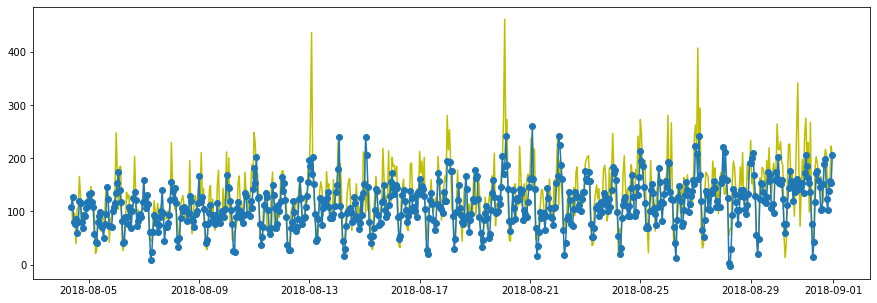

In [21]:
# Построение графика с наложением прогноза модели на ключевой признак
plt.figure(figsize=(15, 5))
plt.plot(target_test.index,
         target_test,
         'y-',
         target_test.index,
         predictions_test,
         'o-')

### Вывод:

Целевая метрика RMSE < 48 достигнута. LinearRegression на тестовой выборке показывает погрешность в 43,65 (44) заказов в час.

## Общий вывод

Нами проведен анализ и построение моделей для предсказания количества заказов такси в аэропотах на ближайший час. Из данных видно, что в заказах такси есть определенный тренд, и он идет на увеличение. Говорить о сезонности сложно, т.к. количество данных сильно ограничено. Однако, в рамках рассмотрения данных за 1 сутки, можно увидеть, что существуют суточные колебания в заказах такси, пик которых приходится на ночные и вечерник часы, а минимум на утренние. Суточные колебания однородны изо дня в день.

На основании имеющихся данных нами проведена их предобработка, после чего обучены три модели - LinearRegression, LGBMRegressor и CatBoostRegressor. По итогам их обучения самой сильной моделью оказался LinearRegression с прогностическим отклонением по RMSE в 26.44 заказов в час.

По итогам проверки LinearRegression на тестовых данных, метрика RMSE ухудшилась, однако находится в допустимом для данной работы диапозоне (RMSE < 48) и составляет отклонение в 43.65 заказов в час.